# Ocean Transports -- Integration And Mapping

Transports in the climate system are often represented as gridded vector fields (e.g. on a `C-grid`) and integrated across model grid lines. These paths may for examples connect a pair of coordinates, or track latitude circles. For more detail, please refer to [Forget et al, 2015](https://doi.org/10.5194/gmd-8-3071-2015) and appendices.

### Read grid & transports from file

1. pre-requisites
2. read transports

In [1]:
using MeshArrays, Plots, Statistics
pth=dirname(pathof(MeshArrays))
include(joinpath(pth,"../examples/Plots.jl"))
include("helper_functions.jl")

pth=MeshArrays.GRID_LLC90
γ=GridSpec("LatLonCap",pth)
Γ=GridLoad(γ)
(Tx,Ty,τx,τy,η)=trsp_read("LatLonCap",pth);

Prepare for visualization:

In [2]:
μ =Γ["hFacC"][:,1]
μ[findall(μ.>0.0)].=1.0
μ[findall(μ.==0.0)].=NaN

lon=[i for i=-179.:2.0:179., j=-89.:2.0:89.]
lat=[j for i=-179.:2.0:179., j=-89.:2.0:89.]

#(f,i,j,w)=InterpolationFactors(Γ,vec(lon),vec(lat))
#λ=(lon=lon,lat=lat,f=f,i=i,j=j,w=w);
#df = DataFrame(f=λ.f[:], i=λ.i[:], j=λ.j[:], w=Float32.(λ.w[:]));
#CSV.write("interp_coeffs.csv", df)

df=DataFrame(CSV.File("interp_coeffs.csv"))
λ=(f=reshape(df.f,length(lon[:]),4), i=reshape(df.i,length(lon[:]),4),
    j=reshape(df.j,length(lon[:]),4), w=reshape(df.w,length(lon[:]),4));

### Integrate transport across latitude lines

1. `LatitudeCircles` computes `grid edge path`s that track latitude circles
2. `ThroughFlow` integrates transports accross the specified `grid edge path`s
3. Plot integrated meridional transport in `Sverdrup` units (1Sv=10^6 m³/s)

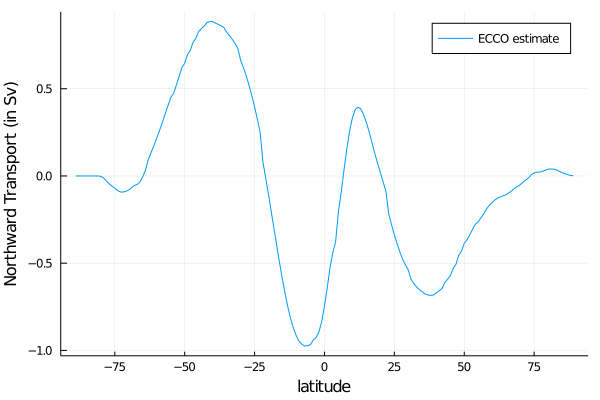

In [3]:
uv=Dict("U"=>Tx,"V"=>Ty,"dimensions"=>["x","y"])
L=-89.0:89.0; LC=LatitudeCircles(L,Γ)

T=Array{Float64,1}(undef,length(LC))
[T[i]=1e-6*ThroughFlow(uv,LC[i],Γ) for i=1:length(LC)]

plot(L,T,xlabel="latitude",ylabel="Northward Transport (in Sv)",label="ECCO estimate")

## Transport Directions

1. `u,v` are oriented in standard `Eastward,Northward` directions
2. `uC,vC` are oriented along the `x,y` directions of each subdomain

In [4]:
u,v,uC,vC=rotate_uv(uv,Γ);

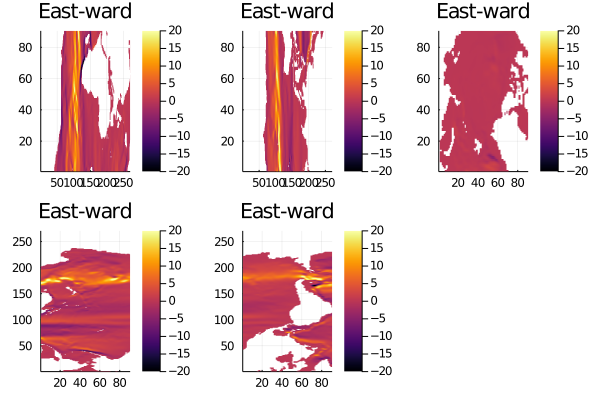

In [5]:
heatmap(u,clims=(-20.0,20.0),title="East-ward")
#heatmap(v,clims=(-20.0,20.0),title="North-ward")

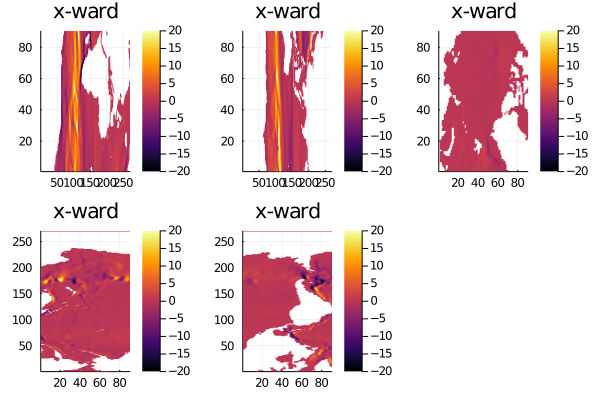

In [6]:
heatmap(uC,clims=(-20.0,20.0),title="x-ward")
#heatmap(vC,clims=(-20.0,20.0),title="y-ward")

### Global Maps

1. interpolate `u,v` to a `1/2 x 1/2` degree grid for plotting
2. map out the Eastward,Northward transport components

In [7]:
uI=reshape(Interpolate(u,λ.f,λ.i,λ.j,λ.w),size(lon))
vI=reshape(Interpolate(v,λ.f,λ.i,λ.j,λ.w),size(lon))
size(lon)

(180, 90)

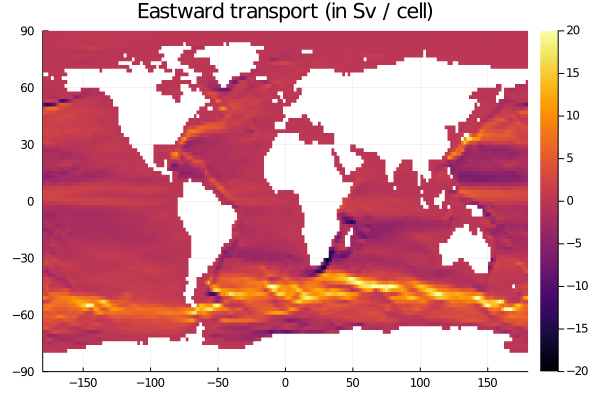

In [8]:
heatmap(lon[:,1],lat[1,:],
    permutedims(uI),clims=(-20.0,20.0),
    title="Eastward transport (in Sv / cell)")

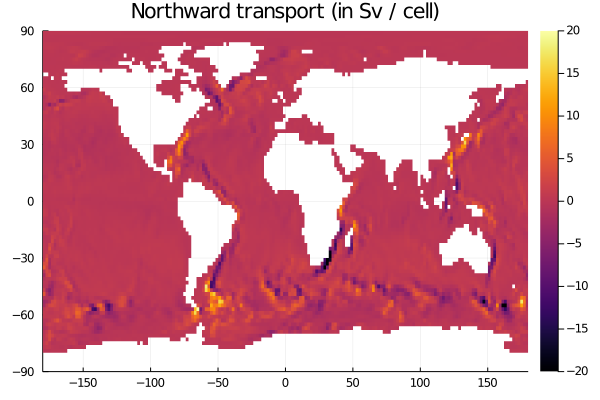

In [9]:
heatmap(lon[:,1],lat[1,:],
    permutedims(vI),clims=(-20.0,20.0),
    title="Northward transport (in Sv / cell)")